In [9]:
import time
import pickle
import glob
import os
import pprint
import datetime
import warnings
import pandas as pd
import numpy as np
import bench_util as bu
import graph_util as gu
import template_util
import shutil
import settings       # the file holding settings for this script
from importlib import reload

In [22]:
# import matplotlib pyplot commands
from matplotlib.pyplot import *
 
# Show Plots in the Notebook
%matplotlib inline
 
# 'style' the plot like fivethirtyeight.com website
style.use('bmh')

rcParams['figure.figsize']= (10, 8)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart

# or if imported as plt
import matplotlib.pyplot as plt
plt.style.use('bmh')

## Examine Distribution of Utility Bill Dates in ARIS data

In [10]:
dfaris = pd.read_pickle('data/aris_records.pkl')
dfaris.head()

,Site ID,Cost,Usage,Service Name,Units,Thru,From,Item Description,Account Number,Vendor Name
0,1,10472.0,129800.0,Electric,kWh,2009-01-15,2008-12-16,Energy,,
1,1,9768.0,117600.0,Electric,kWh,2009-02-15,2009-01-15,Energy,,
2,1,11883.0,116000.0,Electric,kWh,2009-03-15,2009-02-15,Energy,,
3,1,15421.0,158800.0,Electric,kWh,2009-04-15,2009-03-15,Energy,,
4,1,13802.0,137400.0,Electric,kWh,2009-05-15,2009-04-15,Energy,,


In [18]:
dfaris['Thru_year'] = [x.year for x in dfaris.Thru]
dfaris.head()

,Site ID,Cost,Usage,Service Name,Units,Thru,From,Item Description,Account Number,Vendor Name,Thru_year
0,1,10472.0,129800.0,Electric,kWh,2009-01-15,2008-12-16,Energy,,,2009
1,1,9768.0,117600.0,Electric,kWh,2009-02-15,2009-01-15,Energy,,,2009
2,1,11883.0,116000.0,Electric,kWh,2009-03-15,2009-02-15,Energy,,,2009
3,1,15421.0,158800.0,Electric,kWh,2009-04-15,2009-03-15,Energy,,,2009
4,1,13802.0,137400.0,Electric,kWh,2009-05-15,2009-04-15,Energy,,,2009


In [19]:
site_yr = list(set(zip(dfaris['Site ID'], dfaris.Thru_year)))
len(site_yr)

3448

In [21]:
dfsu = pd.DataFrame(site_yr, columns=['site_id', 'year'])
dfsu.head()

,site_id,year
0,62,2011
1,14088,2009
2,14132,2010
3,14425,2015
4,128,2009


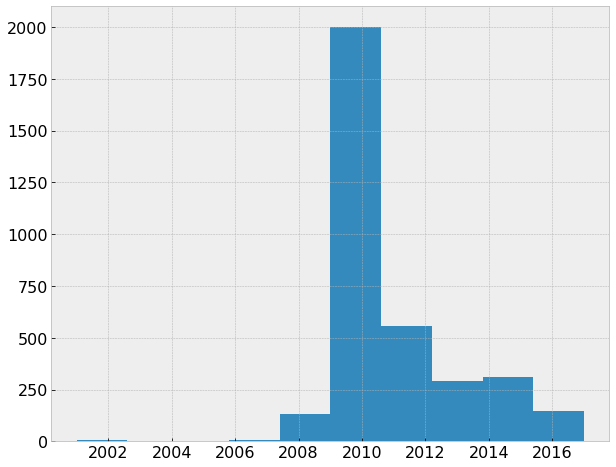

In [23]:
dfsu.year.hist()

Text(0,0.5,'Number of Sites')

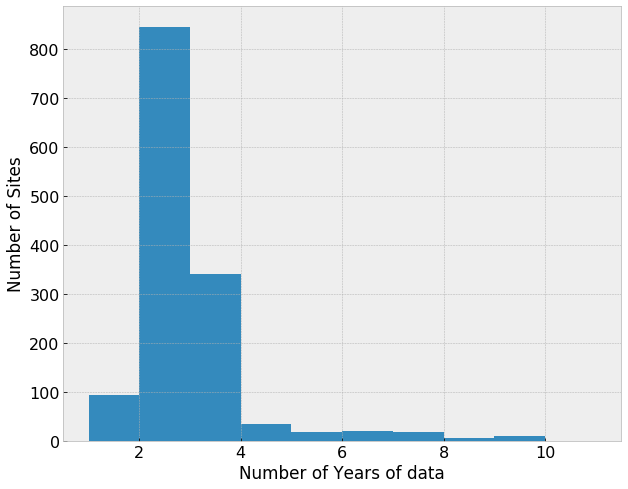

In [26]:
df_yr_ct = dfsu.groupby('site_id').count()
df_yr_ct.year.hist()
xlabel('Number of Years of data')
ylabel('Number of Sites')

In [27]:
df_yr_ct.query('year > 8')

,year
site_id,
1,9
792,9
808,11
14228,9
14257,9
14258,9
14338,9
14360,9
14361,9


In [28]:
len(df_yr_ct)

1390

## Prep for ECI/EUI Comparison Graphs

In [2]:
df = pickle.load(open('df_processed.pkl', 'rb'))
ut = pickle.load(open('util_obj.pkl', 'rb'))
df.head()

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,usage,mmbtu,fiscal_year,fiscal_mo
0,1,electricity,2008,12,Demand Charge,kW,0.000000,120.796667,0.000000,2009,6
1,1,electricity,2008,12,Energy,kWh,5410.533333,67063.333333,228.820093,2009,6
2,1,electricity,2009,1,Demand Charge,kW,0.000000,260.864624,0.000000,2009,7
3,1,electricity,2009,1,Energy,kWh,10260.563441,125330.215054,427.626694,2009,7
4,1,electricity,2009,2,Demand Charge,kW,0.000000,262.817281,0.000000,2009,8


In [7]:
last_complete_year = 2017
df1 = df.query('fiscal_year == @last_complete_year')

# Get Total Utility cost by building. This includes non-energy utilities as well.
df2 = df1.pivot_table(index='site_id', values=['cost'], aggfunc=np.sum)
df2['fiscal_year'] = last_complete_year
df2.reset_index(inplace=True)
df2.set_index(['site_id', 'fiscal_year'], inplace=True)
df2 = bu.add_month_count_column_by_site(df2, df1)
df2.head()

,,cost,month_count
site_id,fiscal_year,,
1,2017,11939.710000,6
13638,2017,21538.633257,10
13639,2017,10704.929431,10
13641,2017,4943.536127,11
13643,2017,4785.318382,10


In [8]:
df2.query('month_count==12').head()

,,cost,month_count
site_id,fiscal_year,,
13748,2017,6205.149833,12
747,2017,32359.491478,12
772,2017,64670.240457,12
774,2017,147561.139500,12
781,2017,85062.210833,12


In [60]:
df.sum()

site_id         0303030303030303030303030303030303030303030303...
service_type    electricityelectricityelectricityelectricityel...
cal_year                                                149389505
cal_mo                                                     480749
item_desc       Electricity chargeElectricity chargeElectricit...
units           kWhkWhkWhkWhkWhkWh-kWh-kWhkWhkWhkWhkWhkWhkWhkW...
cost                                                  1.09128e+08
usage                                                 9.58777e+08
mmbtu                                                 3.08194e+06
fiscal_year                                             149426453
fiscal_mo                                                  482969
dtype: object

In [61]:
df.service_type.unique()

array(['electricity', 'fuel_oil', 'natural_gas', 'refuse', 'sewer',
       'water', 'district_heat'], dtype=object)

In [33]:
reload(bu)

# Filter down to only services that are energy services.
energy_services = bu.missing_energy_services([])
df4 = df.query('service_type==@energy_services').copy()

# Sum Energy Costs and Usage
df5 = pd.pivot_table(df4, index=['site_id', 'fiscal_year'], values=['cost', 'mmbtu'], aggfunc=np.sum)
df5.head()

cost        mmbtu
site_id fiscal_year                            
03      2006          57349.859443  2736.046098
        2007         104483.553127  4365.666281
        2008         129628.412410  4202.356387
        2009         108600.953368  4003.379143
        2010         115833.893536  3686.695168

In [34]:
# Add a column showing number of months present in each fiscal year.
df5 = bu.add_month_count_column_by_site(df5, df4)
df5.head()

cost        mmbtu  month_count
site_id fiscal_year                                         
03      2006          57349.859443  2736.046098            7
        2007         104483.553127  4365.666281           12
        2008         129628.412410  4202.356387           12
        2009         108600.953368  4003.379143           12
        2010         115833.893536  3686.695168           12

In [35]:
dfe = df4.query("service_type=='Electricity'").groupby(['site_id', 'fiscal_year']).sum()[['mmbtu']]
dfe.rename(columns={'mmbtu': 'elec_mmbtu'}, inplace = True)
df5 = df5.merge(dfe, how='left', left_index=True, right_index=True)
df5['elec_mmbtu'] = df5['elec_mmbtu'].fillna(0.0)
df5['heat_mmbtu'] = df5.mmbtu - df5.elec_mmbtu
df5.head()
                  

cost        mmbtu  month_count   elec_mmbtu  \
site_id fiscal_year                                                         
03      2006          57349.859443  2736.046098            7   863.836098   
        2007         104483.553127  4365.666281           12  1446.018281   
        2008         129628.412410  4202.356387           12  1415.147115   
        2009         108600.953368  4003.379143           12  1487.590416   
        2010         115833.893536  3686.695168           12  1453.957168   

                      heat_mmbtu  
site_id fiscal_year               
03      2006         1872.210000  
        2007         2919.648000  
        2008         2787.209273  
        2009         2515.788727  
        2010         2232.738000

In [36]:
# Create a DataFrame with site, year, month and degree-days, but only one row
# for each site/year/month combo.
dfd = df4[['site_id', 'fiscal_year', 'fiscal_mo']].copy()
dfd.drop_duplicates(inplace=True)
ut.add_degree_days_col(dfd)
# Use the agg function below so that a NaN will be returned for the year
# if any monthly values are NaN
dfd = dfd.groupby(['site_id', 'fiscal_year']).agg({'degree_days': lambda x: np.sum(x.values)})[['degree_days']]
dfd.head()    

degree_days
site_id fiscal_year             
03      2006                 NaN
        2007                 NaN
        2008                 NaN
        2009             14388.3
        2010             13186.1

In [37]:
df5 = df5.merge(dfd, how='left', left_index=True, right_index=True)
df5.head()

cost        mmbtu  month_count   elec_mmbtu  \
site_id fiscal_year                                                         
03      2006          57349.859443  2736.046098            7   863.836098   
        2007         104483.553127  4365.666281           12  1446.018281   
        2008         129628.412410  4202.356387           12  1415.147115   
        2009         108600.953368  4003.379143           12  1487.590416   
        2010         115833.893536  3686.695168           12  1453.957168   

                      heat_mmbtu  degree_days  
site_id fiscal_year                            
03      2006         1872.210000          NaN  
        2007         2919.648000          NaN  
        2008         2787.209273          NaN  
        2009         2515.788727      14388.3  
        2010         2232.738000      13186.1

In [38]:
# Add in some needed building like square footage, primary function 
# and building category.
df_bldg = ut.building_info_df()
df_bldg.head()

,acct_elec,acct_nat_gas,acct_oil,acct_refuse,acct_sewer,acct_steam,acct_water,address,city,dd_site,...,site_name,source_elec,source_nat_gas,source_oil,source_refuse,source_sewer,source_steam,source_water,sq_ft,year_built
site_id,,,,,,,,,,,,,,,,,,,,,
03,172230-5,10283 - DENALI,55010001,AW23-DNL03,1998005610,,"1998005610, 1998073600",NaN,NaN,PAFA,...,SD-Denali Elementary,Golden Valley Electric,Fairbanks Natural Gas,Sourdough Fuel (Petro Star),Alaska Waste,Golden Heart Utilities,,Golden Heart Utilities,49210.0,NaN
04,172995-3,10283 - NORDALE,55017001,AW16-NDL04,2440271010,,2440271010,NaN,NaN,PAFA,...,SD-Nordale Elementary,Golden Valley Electric,Fairbanks Natural Gas,Sourdough Fuel (Petro Star),Alaska Waste,Golden Heart Utilities,,Golden Heart Utilities,49210.0,NaN
05,"104270-4, 104271-2, 321383, 357683, 577004",,55016001,AW17-LTH05,1918027500,"08-112-0, 08-113-0",1918027500,NaN,NaN,PAFA,...,SD-Lathrop High,Golden Valley Electric,,Sourdough Fuel (Petro Star),Alaska Waste,Golden Heart Utilities,Aurora Energy,Golden Heart Utilities,234412.0,NaN
06,112356-1,10283 - HUNTER,55012001,AW21-HNT06,1995007000,,1995007000,NaN,NaN,PAFA,...,SD-Hunter Elementary,Golden Valley Electric,Fairbanks Natural Gas,Sourdough Fuel (Petro Star),Alaska Waste,Golden Heart Utilities,,Golden Heart Utilities,57047.0,NaN
07,76471-2,10283-U-PARK,55028001,AW04-UPK07,4012700710,,4012700710,NaN,NaN,PAFA,...,SD-University Park Elementary,Golden Valley Electric,Fairbanks Natural Gas,Sourdough Fuel (Petro Star),Alaska Waste,College Utilities,,College Utilities,64699.0,NaN


In [39]:
# Shrink to just the needed fields and remove index
df_info = df_bldg[['sq_ft', 'site_category', 'primary_func']].copy().reset_index()

# Remove the index from df5 so that merging is easier.
df5.reset_index(inplace=True)

# merge in building info
df5 = df5.merge(df_info, how='left')
df5.head()

,site_id,fiscal_year,cost,mmbtu,month_count,elec_mmbtu,heat_mmbtu,degree_days,sq_ft,site_category,primary_func
0,03,2006,57349.859443,2736.046098,7,863.836098,1872.210000,NaN,49210.0,School District,NaN
1,03,2007,104483.553127,4365.666281,12,1446.018281,2919.648000,NaN,49210.0,School District,NaN
2,03,2008,129628.412410,4202.356387,12,1415.147115,2787.209273,NaN,49210.0,School District,NaN
3,03,2009,108600.953368,4003.379143,12,1487.590416,2515.788727,14388.3,49210.0,School District,NaN
4,03,2010,115833.893536,3686.695168,12,1453.957168,2232.738000,13186.1,49210.0,School District,NaN


In [40]:
df5.tail()

,site_id,fiscal_year,cost,mmbtu,month_count,elec_mmbtu,heat_mmbtu,degree_days,sq_ft,site_category,primary_func
1404,WSPSWP,2014,253228.886807,7445.955719,12,1994.479737,5451.475982,12573.3,28270.0,Other,NaN
1405,WSPSWP,2015,201691.953429,6668.185875,12,1921.952304,4746.233571,12457.2,28270.0,Other,NaN
1406,WSPSWP,2016,170604.147690,7244.765695,12,2019.561766,5225.203929,12172.3,28270.0,Other,NaN
1407,WSPSWP,2017,213829.628103,7385.673697,12,2414.959835,4970.713862,13803.2,28270.0,Other,NaN
1408,WSPSWP,2018,22344.175587,941.033927,3,222.028145,719.005781,857.9,28270.0,Other,NaN


In [41]:
# Look at one that is missing from Building Info to see if
# Left join worked.
df5.query('site_id == "TWOCOM"')

,site_id,fiscal_year,cost,mmbtu,month_count,elec_mmbtu,heat_mmbtu,degree_days,sq_ft,site_category,primary_func
1366,TWOCOM,2006,306.705514,17.604555,4,0.0,17.604555,NaN,NaN,NaN,NaN
1367,TWOCOM,2007,599.014486,40.175445,5,0.0,40.175445,NaN,NaN,NaN,NaN
1368,TWOCOM,2008,1385.656995,58.542785,5,0.0,58.542785,NaN,NaN,NaN,NaN
1369,TWOCOM,2009,1340.892670,86.321904,12,0.0,86.321904,NaN,NaN,NaN,NaN
1370,TWOCOM,2010,752.410335,42.380311,8,0.0,42.380311,NaN,NaN,NaN,NaN


In [42]:
df5['eui'] = df5.mmbtu * 1e3 / df5.sq_ft
df5['eci'] = df5.cost / df5.sq_ft
df5['specific_eui'] = df5.heat_mmbtu * 1e6 / df5.degree_days / df5.sq_ft

# Restrict to full years
df5 = df5.query("month_count == 12").copy()
df5.head()

,site_id,fiscal_year,cost,mmbtu,month_count,elec_mmbtu,heat_mmbtu,degree_days,sq_ft,site_category,primary_func,eui,eci,specific_eui
1,03,2007,104483.553127,4365.666281,12,1446.018281,2919.648000,NaN,49210.0,School District,NaN,88.715023,2.123218,NaN
2,03,2008,129628.412410,4202.356387,12,1415.147115,2787.209273,NaN,49210.0,School District,NaN,85.396391,2.634188,NaN
3,03,2009,108600.953368,4003.379143,12,1487.590416,2515.788727,14388.3,49210.0,School District,NaN,81.352960,2.206888,3.553132
4,03,2010,115833.893536,3686.695168,12,1453.957168,2232.738000,13186.1,49210.0,School District,NaN,74.917601,2.353869,3.440868
5,03,2011,133904.976207,3915.629866,12,1497.110866,2418.519000,13761.4,49210.0,School District,NaN,79.569800,2.721093,3.571359


In [43]:
df5 = df5[['site_id', 'fiscal_year', 'eui', 'eci', 'specific_eui', 'site_category', 'primary_func']].copy()
df5.head()

,site_id,fiscal_year,eui,eci,specific_eui,site_category,primary_func
1,03,2007,88.715023,2.123218,NaN,School District,NaN
2,03,2008,85.396391,2.634188,NaN,School District,NaN
3,03,2009,81.352960,2.206888,3.553132,School District,NaN
4,03,2010,74.917601,2.353869,3.440868,School District,NaN
5,03,2011,79.569800,2.721093,3.571359,School District,NaN


In [44]:
df5.to_pickle('df5.pkl')

In [45]:
pd.read_pickle('df5.pkl').head()

,site_id,fiscal_year,eui,eci,specific_eui,site_category,primary_func
1,03,2007,88.715023,2.123218,NaN,School District,NaN
2,03,2008,85.396391,2.634188,NaN,School District,NaN
3,03,2009,81.352960,2.206888,3.553132,School District,NaN
4,03,2010,74.917601,2.353869,3.440868,School District,NaN
5,03,2011,79.569800,2.721093,3.571359,School District,NaN


In [67]:
site_id = '03'
df = pd.read_pickle('df_processed.pkl', compression='bz2')
df_utility_cost = pd.read_pickle('df_utility_cost.pkl')
df_usage = pd.read_pickle('df_usage.pkl')
util_obj = pickle.load(open('util_obj.pkl', 'rb'))

In [68]:
df_utility_cost.head()

service_type,fiscal_year,electricity,fuel_oil,natural_gas,refuse,sewer,water,district_heat,wood,propane,total,pct_change,hdd,month_count
0,2017,75242.720323,17433.66,517.528982,573.200000,2074.419085,3334.514018,0.0,0.0,0.0,99176.042407,-0.110941,13803.2,12
1,2016,72445.857903,25462.23,2694.708115,5090.637097,2066.956295,3791.325907,0.0,0.0,0.0,111551.715317,-0.185473,12172.3,12
2,2015,75784.554854,9563.85,39581.266774,6306.468065,1890.176452,3826.449466,0.0,0.0,0.0,136952.765610,-0.003598,12457.2,12
3,2014,81601.473207,NaN,46027.607639,4896.148710,1929.392097,2992.671545,0.0,0.0,0.0,137447.293198,-0.087807,12573.3,12
4,2013,87440.417303,NaN,53711.881877,4615.909839,1926.701571,2982.969243,0.0,0.0,0.0,150677.879833,0.024418,14901.4,12


In [71]:
df_usage.head()

,electricity_mmbtu,fuel_oil_mmbtu,natural_gas_mmbtu,district_heat_mmbtu,wood_mmbtu,propane_mmbtu,total_energy_mmbtu,electricity_pct,fuel_oil_pct,natural_gas_pct,district_heat_pct,wood_pct,propane_pct,hdd,total_heat_mmbtu,total_specific_heat
fiscal_year,,,,,,,,,,,,,,,,
2017,1007.401282,1280.880,0.000000,0.0,0.0,0.0,2288.281282,0.440244,0.559756,0.000000,0.0,0.0,0.0,13803.2,1280.880000,92.795873
2016,1262.055985,2455.920,100.094903,0.0,0.0,0.0,3818.070888,0.330548,0.643236,0.026216,0.0,0.0,0.0,12172.3,2556.014903,209.986190
2015,1249.697374,507.735,1939.536581,0.0,0.0,0.0,3696.968955,0.338033,0.137338,0.524629,0.0,0.0,0.0,12457.2,2447.271581,196.454386
2014,1358.678778,NaN,2261.606516,0.0,0.0,0.0,3620.285295,0.375296,NaN,0.624704,0.0,0.0,0.0,12573.3,2261.606516,179.873742
2013,1387.527937,NaN,2647.130323,0.0,0.0,0.0,4034.658260,0.343902,NaN,0.656098,0.0,0.0,0.0,14901.4,2647.130323,177.643062
